<a href="https://colab.research.google.com/github/Evangenajohn/Used-Car-Price-Prediction/blob/main/Car_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")


In [2]:
from google.colab import files
uploaded = files.upload()

Saving CAR DETAILS FROM CAR DEKHO.csv to CAR DETAILS FROM CAR DEKHO.csv


In [3]:
import pandas as pd

# Load the uploaded file
df = pd.read_csv('CAR DETAILS FROM CAR DEKHO.csv')
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [4]:
df.drop_duplicates(inplace=True)

In [5]:
print("\n🧹 Null values:")
print(df.isnull().sum())


🧹 Null values:
name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
dtype: int64


In [6]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [7]:
# Drop duplicates based on all features except 'name'
df = df.drop_duplicates(subset=[col for col in df.columns if col != 'name'])

# Extract brand from name for feature engineering
df['brand'] = df['name'].apply(lambda x: x.split()[0])

# Optionally keep or drop 'name'
df.drop('name', axis=1, inplace=True)  # Only drop if you're not using the full name elsewhere

In [8]:
# Convert year to car age
df['car_age'] = 2025 - df['year']
df.drop('year', axis=1, inplace=True)

In [9]:
# Rearranging columns
df = df[['brand', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'car_age', 'selling_price']]


In [26]:
#Create km_per_year (usage intensity)
df['km_per_year'] = df['km_driven'] / df['car_age']
df['km_per_year'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['km_per_year'].fillna(df['km_per_year'].median(), inplace=True)

In [27]:
#Group Rare Brands into 'Other'
brand_counts = df['brand'].value_counts()
rare_brands = brand_counts[brand_counts < 50].index
df['brand'] = df['brand'].apply(lambda x: 'Other' if x in rare_brands else x)

In [28]:
owner_map = {
    'First Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3,
    'Fourth & Above Owner': 4,
    'Test Drive Car': 0
}
df['owner_encoded'] = df['owner'].map(owner_map)
df.drop('owner', axis=1, inplace=True)

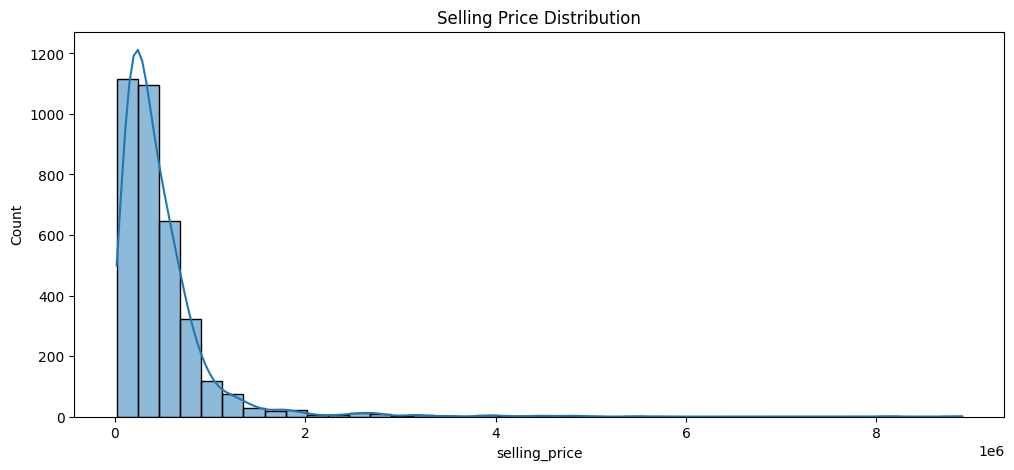

In [10]:
plt.figure(figsize=(12, 5))
sns.histplot(df['selling_price'], bins=40, kde=True)
plt.title('Selling Price Distribution')
plt.show()

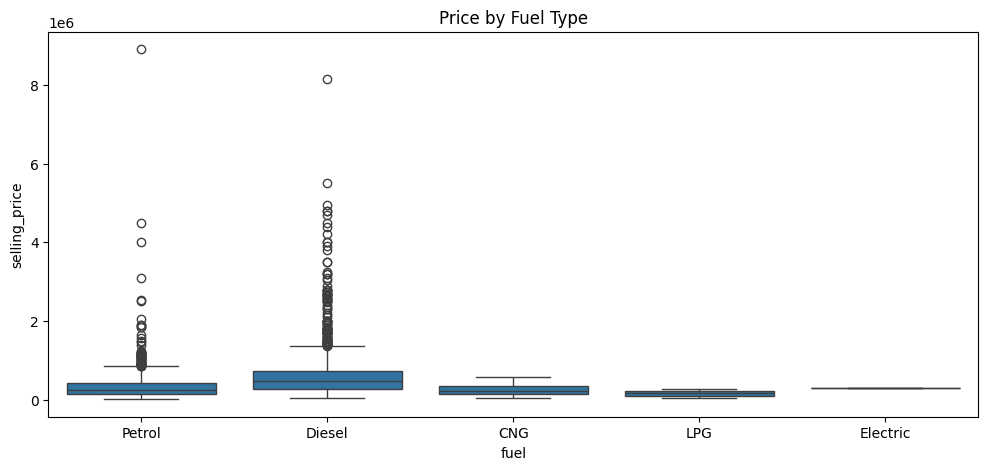

In [11]:
plt.figure(figsize=(12, 5))
sns.boxplot(data=df, x='fuel', y='selling_price')
plt.title('Price by Fuel Type')
plt.show()

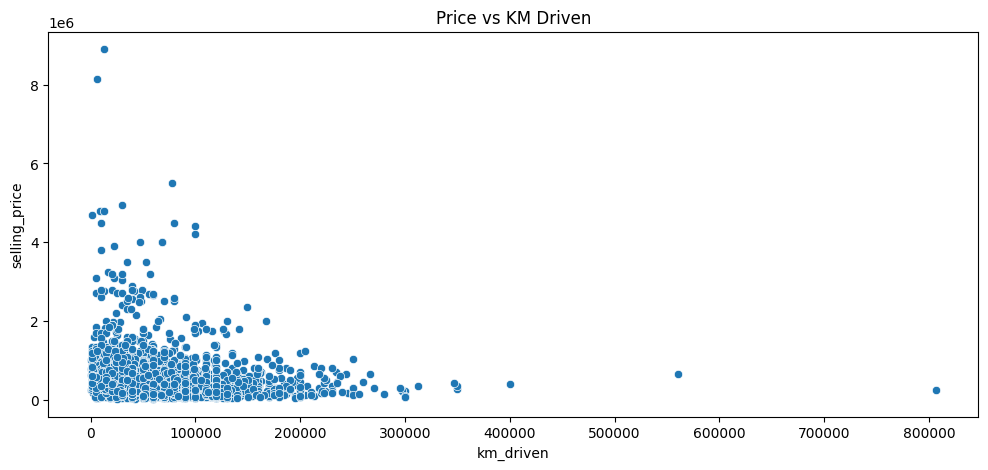

In [12]:
plt.figure(figsize=(12, 5))
sns.scatterplot(data=df, x='km_driven', y='selling_price')
plt.title('Price vs KM Driven')
plt.show()

In [13]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    cleaned_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    print(f"🧹 Removed outliers from '{column}': {df.shape[0] - cleaned_df.shape[0]} rows dropped")
    return cleaned_df

# Apply to your key columns
df_clean = remove_outliers_iqr(df, 'selling_price')
df_clean = remove_outliers_iqr(df_clean, 'km_driven')
df_clean = remove_outliers_iqr(df_clean, 'car_age')


🧹 Removed outliers from 'selling_price': 169 rows dropped
🧹 Removed outliers from 'km_driven': 121 rows dropped
🧹 Removed outliers from 'car_age': 37 rows dropped


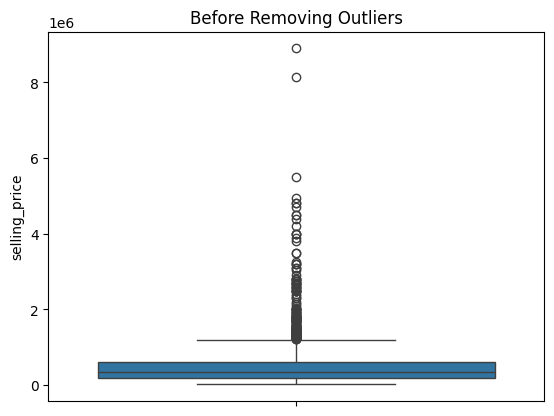

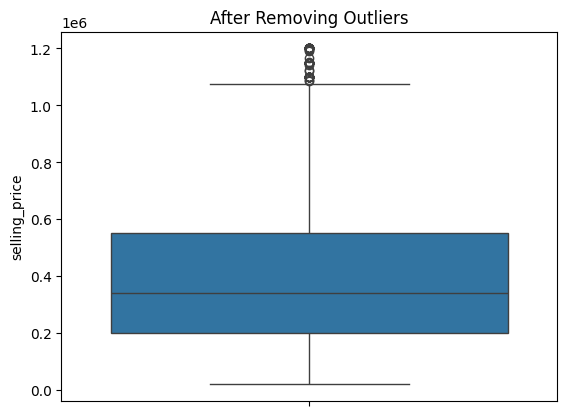

In [14]:
# Before
sns.boxplot(df['selling_price'])
plt.title("Before Removing Outliers")
plt.show()

# After
sns.boxplot(df_clean['selling_price'])
plt.title("After Removing Outliers")
plt.show()


In [29]:
# One-hot encode remaining categorical features
df = pd.get_dummies(df, columns=['brand', 'fuel', 'seller_type'], drop_first=True)

# Final features and target
X = df.drop('selling_price', axis=1)
y = np.log1p(df['selling_price'])  # Log-transformed target

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Assuming 'df_encoded' from previous step is your feature-engineered DataFrame
X = df_encoded.drop('selling_price', axis=1)  # Features
y = df_encoded['selling_price']  # Target variable
# Log transform the target variable (if necessary)
# Make sure y is a pandas Series or NumPy array
y_log = np.log1p(y)
# Only scale X, not y
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use same split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_log, test_size=0.2, random_state=42)

In [21]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [34]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"\n📈 R² Score (Linear Regression): {r2:.4f}")
print(f"📉 MSE: {mse:.2f}")
print(f"📉 RMSE: {rmse:.2f}")


📈 R² Score (Linear Regression): 0.7658
📉 MSE: 0.16
📉 RMSE: 0.40


In [37]:
# Transform target
y_log = np.log1p(y)

# Use same train-test split logic
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Train again
model = LinearRegression()
model.fit(X_train, y_train_log)
y_pred_log = model.predict(X_test)

# Reverse log transform
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test_log)

# Evaluate
r2 = r2_score(y_test_actual, y_pred)
print(f"\n📈 R² Score (Log-Transformed): {r2:.4f}")



📈 R² Score (Log-Transformed): 0.7180


In [44]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"\n📈 R² Score (Linear Regression): {r2:.4f}")
print(f"📉 MSE: {mse:.2f}")
print(f"📉 RMSE: {rmse:.2f}")


📈 R² Score (Linear Regression): 0.7658
📉 MSE: 0.16
📉 RMSE: 0.40


In [45]:
import joblib

# Save your trained model
joblib.dump(model, 'car_price_model.pkl')

['car_price_model.pkl']

In [46]:
from google.colab import files
files.download('car_price_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>